In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set(style="white")
sns.set_context("paper")

def figsize(scale,ratio, fig_width_pt = 505.69): # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [3]:
SUPPLEMENTARY_PT = 418.2555

## Features

In [4]:
crime_df = pd.read_csv('../data/generated_files/crime.csv', names=['sp_id', 'city', 'spatial_name', 'num', 'ucr1', 'ucr_category'])
crime_df = crime_df.rename(columns={'num': 'ncrimes'})
crime_df.head()

,sp_id,city,spatial_name,ncrimes,ucr1,ucr_category
0,318548,boston,ego,2,Robbery,Violent crime
1,318548,boston,ego,9,Burglary (breaking or entering),Property crime
2,318548,boston,ego,0,Criminal homicide,Violent crime
3,318548,boston,ego,0,Rape,Violent crime
4,318548,boston,ego,0,Arson,Property crime


In [5]:
ucr_category_df = crime_df.groupby(['sp_id', 'city', 'spatial_name', 'ucr_category']).sum().pivot_table(index=['city', 'spatial_name', 'sp_id'], columns='ucr_category', values='ncrimes')
ucr1_category_df = crime_df.pivot_table(index=['city', 'spatial_name', 'sp_id'], columns='ucr1', values='ncrimes')
crime_df_sum_df = crime_df.groupby(['city', 'spatial_name', 'sp_id']).sum()
crime_df = pd.merge(ucr_category_df, ucr1_category_df, left_index=True, right_index=True)
crime_df = pd.merge(crime_df, crime_df_sum_df, left_index=True, right_index=True)
crime_df = crime_df.reset_index()
crime_df.head()

,city,spatial_name,sp_id,Property crime,Violent crime,Aggravated assault,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes
0,LA,ego,343071,13,10,4,0,9,0,4,2,4,23
1,LA,ego,343072,14,17,3,0,3,0,11,0,14,31
2,LA,ego,343073,15,13,10,0,7,0,8,2,1,28
3,LA,ego,343074,2,1,1,0,1,0,1,0,0,3
4,LA,ego,343075,17,29,9,0,6,1,11,0,19,46


In [6]:
crime_df.groupby('city').count()

,spatial_name,sp_id,Property crime,Violent crime,Aggravated assault,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes
city,,,,,,,,,,,,
LA,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507
LA1m,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507
bogota,916,916,916,916,916,916,916,916,916,916,916,916
bogota1m,918,918,918,918,918,918,918,918,918,918,918,918
boston,555,555,555,555,555,555,555,555,555,555,555,555
boston1m,555,555,555,555,555,555,555,555,555,555,555,555
chicago,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175
chicago1m,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175,2175


In [7]:
census_df = pd.read_csv('../data/generated_files/aspatial_features.csv')
# Number of employed
census_df.head()

,sp_id,city,spatial_name,land_use_mix3,core_walkscore,avg_block_area,n_blocks,sum_block_area,area_filtr,area_tot,...,core_shops,core_food,core_nightlife,core_schools,core_entertainment,core_residence,core_travel,core_outdoor,core_professional,core_event
0,318548,boston,ego,0.919884,0.605664,8.714231,195.0,1704.974850,1.547197,2.398277,...,3.0,3.0,2.0,0.0,4.0,0.0,3.0,5.0,7.0,0.0
1,318703,boston,ego,0.807951,0.876098,8.605507,322.0,2742.962247,1.740471,3.254301,...,55.0,26.0,33.0,13.0,40.0,15.0,27.0,11.0,29.0,0.0
2,318675,boston,ego,0.813700,0.857428,9.051880,177.0,1579.772385,1.057320,1.731746,...,30.0,3.0,2.0,5.0,3.0,7.0,3.0,0.0,1.0,0.0
3,318557,boston,ego,0.886762,0.916891,8.599881,372.0,3156.694653,1.725410,3.270160,...,149.0,25.0,18.0,30.0,12.0,13.0,6.0,9.0,6.0,0.0
4,318803,boston,ego,0.938155,0.148667,9.669308,120.0,1157.457691,2.445785,3.964465,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0


In [8]:
spatial_groups = census_df[['spatial_name', 'city']].drop_duplicates().values
spatial_groups

array([['ego', 'boston'],
       ['ego', 'boston1m'],
       ['ego', 'bogota'],
       ['ego', 'bogota1m'],
       ['ego', 'chicago'],
       ['ego', 'chicago1m'],
       ['ego', 'LA'],
       ['ego', 'LA1m']], dtype=object)

In [9]:
df = pd.merge(census_df, crime_df, on=['sp_id', 'city', 'spatial_name'], how='left').fillna(0)
df = df.sort_values(['spatial_name', 'city', 'sp_id'])

# Transformations
from sklearn.decomposition import FactorAnalysis, PCA

df['disadvantage'] = 0
df['residential_stability'] = 0
df['small_blocks'] = 0

df.loc[:, 'n_blocks'] = (df['n_blocks']+1)#/np.log(df['sum_block_area']+1)
df.loc[:, 'avg_block_area'] = 1/(df['avg_block_area'])#/np.log(df['sum_block_area']+1)

    
for spatial_group, city in spatial_groups:
    sk = FactorAnalysis(1)
    if 'bogota' in city:
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'disadvantage'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['unemployed', 'poverty_index']].fillna(0).values)
    else:
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'disadvantage'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['unemployed', 'poverty_index']].fillna(0).values)
    sk = FactorAnalysis(1)
    df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'residential_stability'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['residential_stable', 'residential_owners']].fillna(0).values)
    sk = FactorAnalysis(1)
    df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'small_blocks'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['avg_block_area', 'n_blocks']].values)


#,
features = [#'area_tot',
            #'core_area_tot',
            
            'land_use_mix3',
            'small_blocks',
            
            'building_diversity2',
            'vacant_land',
            
            'density_population',
            'building_density',
            
            'core_walkscore',
            
            'core_population', 'core_nightlife',
            'core_shops',
                         'core_food', 'distance_bld_roads'
            #'population'
            #'median_income_std'
           ] #, 
features.append('ncrimes')
#df['ncrimes'] /= df['population']

df.head()

,sp_id,city,spatial_name,land_use_mix3,core_walkscore,avg_block_area,n_blocks,sum_block_area,area_filtr,area_tot,...,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes,disadvantage,residential_stability,small_blocks
8316,343071,LA,ego,0.480121,0.461243,0.097238,92.0,943.728510,2.738677,3.681045,...,0,9,0,4,2,4,23,-0.052040,-0.993910,-1.085686
9750,343072,LA,ego,0.695312,0.547243,0.100349,155.0,1527.888609,2.409828,3.473708,...,0,3,0,11,0,14,31,1.145566,-0.151944,0.098992
8465,343073,LA,ego,0.118187,0.576569,0.095583,92.0,955.184044,3.341140,4.507610,...,0,7,0,8,2,1,28,0.001936,0.413490,-1.085786
8437,343074,LA,ego,0.538321,0.518607,0.101778,123.0,1210.552761,3.015941,3.844081,...,0,1,0,1,0,0,3,-0.200807,-0.383915,-0.502566
7871,343075,LA,ego,0.394799,0.865886,0.100546,195.0,1936.012117,3.223308,4.526008,...,0,6,1,11,0,19,46,-0.078711,0.482378,0.851061


In [10]:
crime_df[crime_df.sp_id == 184043]

,city,spatial_name,sp_id,Property crime,Violent crime,Aggravated assault,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes


In [11]:
interesting_features = ['land_use_mix3',
                       'small_blocks',

                       'building_diversity2',

                       'density_dwellings',

                       #'vacuums_sim_w',
                       'core_walkscore',
                        'disadvantage',
        'ethnic_diversity',
        'residential_stability',
                        'core_population', 'core_nightlife',
                     'vacant_land', 'core_shops',
                         'core_food','distance_bld_roads', 'ncrimes', 'core_ambient', 'attractiveness'
                       ]

df_transform = df.copy()
df_transform.loc[:, interesting_features] = (df_transform[interesting_features] - df_transform[interesting_features].mean()) / df_transform[interesting_features].std()
df_transform[['sp_id'] + interesting_features][df_transform.sp_id.isin([184043, 182184])].T

""
sp_id
land_use_mix3
small_blocks
building_diversity2
density_dwellings
core_walkscore
disadvantage
ethnic_diversity
residential_stability
core_population


In [12]:
df[df.sp_id == 182265][interesting_features].T

""
land_use_mix3
small_blocks
building_diversity2
density_dwellings
core_walkscore
disadvantage
ethnic_diversity
residential_stability
core_population
core_nightlife


In [13]:
df_transform[df_transform.sp_id == 182265][interesting_features].T

""
land_use_mix3
small_blocks
building_diversity2
density_dwellings
core_walkscore
disadvantage
ethnic_diversity
residential_stability
core_population
core_nightlife


(0.47373719516425805, 2.003414166240284e-52)


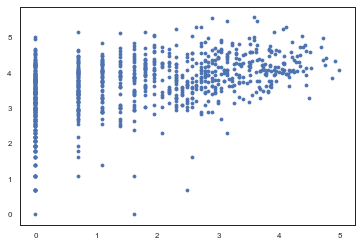

In [14]:
city_to_show = 'bogota'
x_to_show = 'core_food'#, 
y_to_show = 'ncrimes'
plt.scatter(np.log(df[df.city == city_to_show][x_to_show]+1), np.log(df[df.city == city_to_show][y_to_show]+1))
print(stats.pearsonr(np.log(df[df.city == city_to_show][x_to_show]+1), np.log(df[df.city == city_to_show][y_to_show]+1)))

(0.3258993612723434, 4.0754621990580786e-63)


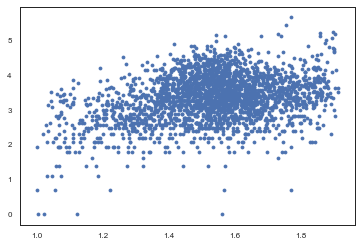

In [15]:
city_to_show = 'LA'
x_to_show = 'core_walkscore'
y_to_show = 'ncrimes'
x = (df[df.city == city_to_show][x_to_show]+1)
y = np.log(df[df.city == city_to_show][y_to_show]+1)
plt.scatter(x,y)
print(stats.pearsonr(x,y))

In [16]:
df2 = df.copy()

In [17]:
df2.loc[:, features] = (df2[features] - df2[features].mean())/df2[features].std()

In [18]:
df_melt = pd.melt(df2[df2.spatial_name == 'ego'], id_vars=['sp_id', 'city', 'spatial_name'], var_name='feature')
df_melt = df_melt[df_melt.feature.isin(features)]
df_melt = df_melt[df_melt.feature != 'pp']
#df_melt = df_melt[df_melt.feature != 'ncrimes']
df_melt.head()

,sp_id,city,spatial_name,feature,value
0,343071,LA,ego,land_use_mix3,-0.703603
1,343072,LA,ego,land_use_mix3,0.289634
2,343073,LA,ego,land_use_mix3,-2.374147
3,343074,LA,ego,land_use_mix3,-0.434971
4,343075,LA,ego,land_use_mix3,-1.097416


In [19]:
df[df.city == 'chicago'].sort_values('ncrimes', ascending=False)[['sp_id', 'ncrimes', 'area_filtr', 'area_tot', 'ncrimes', 'density_population']].head()

,sp_id,ncrimes,area_filtr,area_tot,ncrimes,density_population
5111,274251,172,4.559260,5.465121,172,10959.672621
4051,273460,155,6.679927,6.690989,155,4011.421334
4814,273421,143,3.840070,3.840070,143,4632.207176
4958,273737,138,8.268431,8.422840,138,3046.043566
4816,273982,137,4.944026,5.734375,137,5501.589180


[Text(0, 0, 'land_use_mix3'),
 Text(0, 0, 'core_walkscore'),
 Text(0, 0, 'density_population'),
 Text(0, 0, 'building_density'),
 Text(0, 0, 'vacant_land'),
 Text(0, 0, 'building_diversity2'),
 Text(0, 0, 'core_population'),
 Text(0, 0, 'distance_bld_roads'),
 Text(0, 0, 'core_shops'),
 Text(0, 0, 'core_food'),
 Text(0, 0, 'core_nightlife'),
 Text(0, 0, 'ncrimes'),
 Text(0, 0, 'small_blocks')]

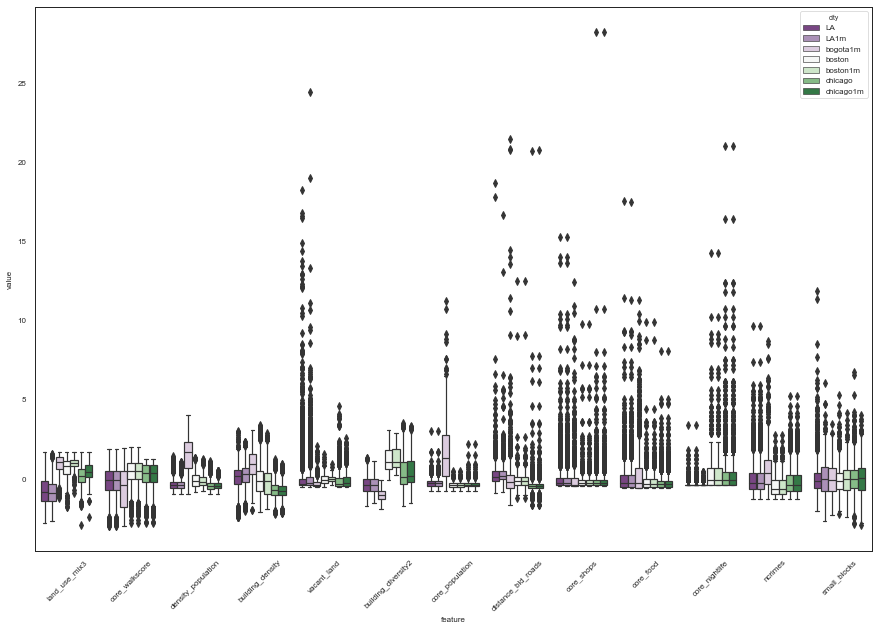

In [20]:
f = plt.figure(figsize=(15,10))
ax = sns.boxplot(x="feature", y="value", hue="city", data=df_melt[df_melt.city != 'bogota'], palette="PRGn")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [21]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
    
        
    for row in range(nrows):
        for col in range(ncols):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

In [22]:
df[df.city == 'bogota'].sort_values(['residential_stability']).tail()

,sp_id,city,spatial_name,land_use_mix3,core_walkscore,avg_block_area,n_blocks,sum_block_area,area_filtr,area_tot,...,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes,disadvantage,residential_stability,small_blocks
1424,348398,bogota,ego,0.908534,0.521775,0.117984,222.0,1910.405390,2.026750,3.332230,...,0,29,0,2,0,13,66,0.322077,0.0,-1.354403
1491,348399,bogota,ego,0.921016,0.490427,0.124332,431.0,3559.810263,1.944431,3.655281,...,0,19,1,1,0,23,57,0.190501,0.0,-0.547960
1769,348400,bogota,ego,0.943606,0.210193,0.115492,188.0,1685.975844,3.065325,5.012385,...,0,18,0,0,0,4,23,-0.698668,0.0,-1.485597
1179,348402,bogota,ego,0.705367,0.493810,0.124313,711.0,5715.347230,1.887460,3.058600,...,0,0,9,0,0,31,53,0.455580,0.0,0.532427
1445,349009,bogota,ego,0.921502,0.266729,0.119879,448.0,3705.342803,1.242397,2.677117,...,0,6,6,1,0,7,42,0.480772,0.0,-0.482373


## Transform

In [23]:
df = pd.merge(census_df, crime_df, on=['sp_id', 'city', 'spatial_name'], how='left').fillna(0)
df = df[df.sp_id != 348359]
df.head()

,sp_id,city,spatial_name,land_use_mix3,core_walkscore,avg_block_area,n_blocks,sum_block_area,area_filtr,area_tot,...,Property crime,Violent crime,Aggravated assault,Arson,Burglary (breaking or entering),Criminal homicide,Motor vehicle theft,Rape,Robbery,ncrimes
0,318548,boston,ego,0.919884,0.605664,8.714231,195.0,1704.974850,1.547197,2.398277,...,16,3,1,0,9,0,7,0,2,19
1,318703,boston,ego,0.807951,0.876098,8.605507,322.0,2742.962247,1.740471,3.254301,...,12,37,25,0,9,0,3,0,12,49
2,318675,boston,ego,0.813700,0.857428,9.051880,177.0,1579.772385,1.057320,1.731746,...,12,7,5,0,7,0,5,0,2,19
3,318557,boston,ego,0.886762,0.916891,8.599881,372.0,3156.694653,1.725410,3.270160,...,9,70,31,0,6,0,3,0,39,79
4,318803,boston,ego,0.938155,0.148667,9.669308,120.0,1157.457691,2.445785,3.964465,...,2,0,0,0,2,0,0,0,0,2


In [24]:
df.loc[:, 'n_blocks'] = -1*np.log(df['n_blocks']/df['area_tot'] + 1)
#df.loc[:, 'avg_block_area'] = np.log(df['avg_block_area'] + 1)
df.loc[:, 'density_population'] = np.sqrt(df['density_population'])
df.loc[:, 'density_dwellings'] = np.sqrt(df['density_dwellings'])  

df['residential_instability'] = 1-df['residential_stable']


for spatial_group, city in spatial_groups:
    '''
    if 'bogotsada' in city:
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'disadvantage'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['unemployed', 'poverty_index', 'poverty_index2_bogota']].fillna(0).values)
    else:
        temp = df[(df.city == city) & (df.spatial_name == spatial_group)][['unemployed', 'poverty_index']].fillna(0).values
        sk = PCA(1, random_state=0)
        sk.fit(temp)
        #print(city, sk.components_)
        if np.sum(sk.components_) < 1:
            temp *= -1
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'disadvantage'] = sk.fit_transform(temp)
    
    if 'bogota' in city:
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'residential_stability'] = df[(df.city == city) & (df.spatial_name == spatial_group)][['residential_stable']].fillna(0).values
    else:
        temp = df[(df.city == city) & (df.spatial_name == spatial_group)][['residential_stable', 'residential_owners']].fillna(0).values
        sk = PCA(1, random_state=0)
        sk.fit(temp)
        if np.sum(sk.components_) < 1:
            temp *= -1
        df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'residential_stability'] = sk.fit_transform(temp)
        
    
    
    temp = df[(df.city == city) & (df.spatial_name == spatial_group)][['density_dwellings', 'building_density']].fillna(0).values
    sk = PCA(1, random_state=0)
    sk.fit(temp)
    #print(c, sk.components_)
    multiplier = 1
    if np.sum(sk.components_) < 1:
        multiplier = -1
    df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'density'] = multiplier*sk.transform(temp)
    '''
    
    
    temp = df[(df.city == city) & (df.spatial_name == spatial_group)][['unemployed', 'poverty_index', 'residential_instability']].fillna(0).values
    sk = PCA(random_state=0)
    sk.fit(temp)
    print("Explained variance", city, sk.explained_variance_ratio_.cumsum())
    
    sk = PCA(2, random_state=0)
    sk.fit(temp)
    print("Components", city, sk.components_, sk.explained_variance_ratio_)
    
    pca_result = sk.transform(temp)
    
    poverty = pca_result[:, 0]
    stability = pca_result[:, 1]
    if np.sum(sk.components_[0, :2]) < np.sum(sk.components_[1, :2]):
        print("switch")
        poverty = pca_result[:, 1]
        stability = pca_result[:, 0]
    
    df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'disadvantage'] = poverty
    df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'residential_stability'] = stability
    print()
    
    #sk = PCA(1)
    #df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'small_blocks'] = sk.fit_transform(df[(df.city == city) & (df.spatial_name == spatial_group)][['avg_block_area', 'n_blocks']].values)

df['small_blocks'] = 1/(df['avg_block_area']+1)
df.loc[:, 'population'] = np.log(df['population'] + 1)
df.loc[:, 'core_population'] = np.sqrt(df['core_population'])
#df['density_population'] = df['population'] / df['area_filtr']
df.loc[:, 'distance_bld_roads'] = np.log(df['distance_bld_roads'] +1)
if 'core_ambient' in df.columns:
    df['ambient'] = df['core_ambient'].copy()
    df.loc[:, 'core_ambient'] = np.log(df['core_ambient']+1)
#df.loc[:, 'avg_block_area'] = (1 / df['avg_block_area'])

'''
for spatial_group, city in spatial_groups:
    t = df[((df.city == city) & (df.spatial_name == spatial_group))]['small_blocks']
    #xt, _ = stats.boxcox((1-t.min())+t+1)
    print((t+10-t.min()).min())
    xt, _ = stats.boxcox(t+2-t.min())
    #df.loc[((df.city == city) & (df.spatial_name == spatial_group)), 'small_blocks'] = xt
'''
#df.loc[:, 'building_density'] = np.log(df['building_density']+ 1)

#df.loc[:, 'walkscore'] = 1 / ((df['walkscore'].max() + 1) - df['walkscore'])

df.loc[:, 'core_shops'] = np.log(df['core_shops'] + 1)
df.loc[:, 'core_nightlife'] = np.log(df['core_nightlife'] + 1)
df.loc[:, 'core_food'] = np.log(df['core_food'] + 1)

df.loc[:, 'nin'] = np.log(df['nin']+ 1)
df.loc[:, 'nout'] = np.log(df['nout']+ 1)
df.loc[:, 'attractiveness'] = np.sqrt(df['attractiveness'])
df['introversion'] = df['nin']/(df['nout']+df['nin'])

Explained variance boston [0.66880465 0.95828569 1.        ]
Components boston [[ 0.04376423  0.69033876  0.72216141]
 [ 0.54384637  0.58990128 -0.59686481]] [0.66880465 0.28948104]
switch

Explained variance boston1m [0.68889811 0.96908301 1.        ]
Components boston1m [[-0.00865348  0.6536365   0.75675917]
 [ 0.57896387  0.62031246 -0.52916281]] [0.68889811 0.28018491]
switch

Explained variance bogota [0.97179932 0.99845536 1.        ]
Components bogota [[ 0.04016442  0.99713888 -0.06403813]
 [-0.09314079  0.06754706  0.99335904]] [0.97179932 0.02665604]

Explained variance bogota1m [0.97963345 0.99891981 1.        ]
Components bogota1m [[ 0.04113842  0.99656234 -0.07191059]
 [ 0.08194287 -0.07509418 -0.99380392]] [0.97963345 0.01928636]

Explained variance chicago [0.74238401 0.95567396 1.        ]
Components chicago [[ 0.54408355  0.83900508  0.00660008]
 [-0.2993525   0.18676547  0.93568517]] [0.74238401 0.21328995]

Explained variance chicago1m [0.74764386 0.96087545 1.       

/home/denadai/.local/share/virtualenvs/crime-environment-u9RldRjF/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


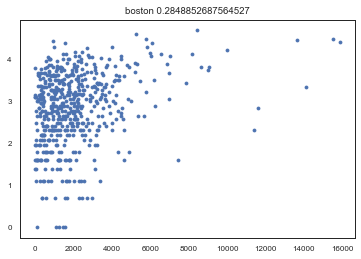

<Figure size 432x288 with 0 Axes>

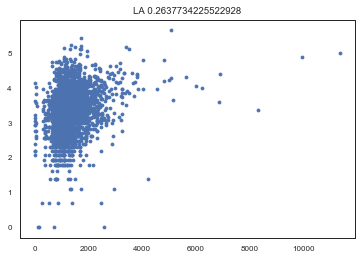

<Figure size 432x288 with 0 Axes>

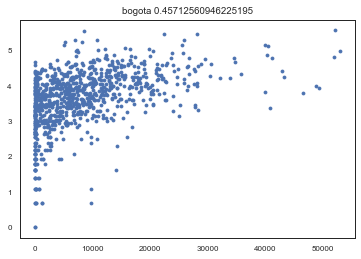

<Figure size 432x288 with 0 Axes>

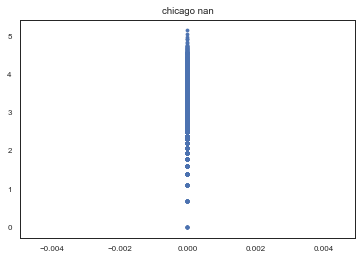

<Figure size 432x288 with 0 Axes>

In [25]:
for c in ['boston', 'LA', 'bogota', 'chicago']:
    
    x = df[(df.city == c)]['ambient']#/df[(df.city == c)]['area_filtr']+1)
    y = np.log(df[(df.city == c)]['ncrimes']+1)
    
    plt.figure()
    plt.scatter(x, y)
    plt.title(c + " " +str(stats.pearsonr(x,y)[0]))
    plt.figure()

In [26]:
jacobs_features = ['land_use_mix3',

					   #'small_blocks',
					   #'distance_bld_roads',

					'building_diversity2',

					'density_dwellings',
					#'vacuums_sim',
					'core_walkscore', #'HBW' ,'HBO', 'NHB'
					   ]

demo_features = [
		'disadvantage',
		'ethnic_diversity',
		#'median_income', 
		'residential_stability'
	]

mobility_features = [
		'core_ambient',
		'attractiveness',
	]


jacobs_features = ['land_use_mix3',

					   'small_blocks',
					   #'distance_bld_roads',

					'building_diversity2',

					'density_dwellings',

					#'vacuums_sim',
					'core_walkscore', #'HBW' ,'HBO', 'NHB'
					   ]

nice_names_mapping = {
    'land_use_mix3': 'Land-use mix',
    'small_blocks': 'Small blocks',
    'building_diversity2': 'Building age diversity',
    'density_dwellings': 'Population density',
    'core_walkscore': 'Walkability',
    'disadvantage': 'Disadvantage',
    'ethnic_diversity': 'Ethnic diversity',
    'residential_stability': 'Instability',
    'core_population': 'Residential population',
    'core_ambient': 'Ambient population',
    'attractiveness': 'Attractiveness',
    
    'core_nightlife': 'Nighlife POIs',
    'core_shops': 'Shops POIs',
    'core_food': 'Food POIs',
}

nice_city_mapping = {
    'boston': 'Boston',
    'LA': 'Los Angeles',
    'bogota': 'Bogota',
    'chicago': 'Chicago'
}

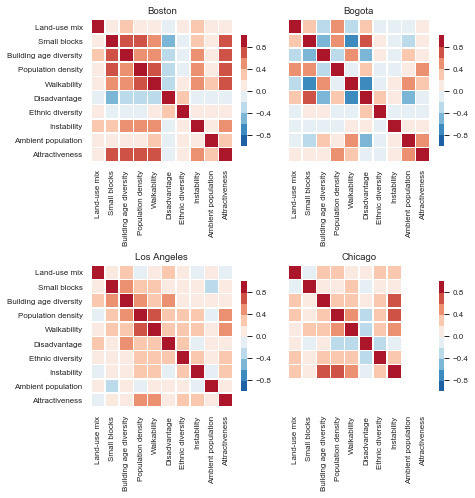

In [27]:
import string

f, axs = plt.subplots(2, 2, sharey = True, figsize=figsize(1.0, 1.20, SUPPLEMENTARY_PT))
f.tight_layout()

cmap = sns.color_palette("RdBu_r", 10)
cities = ['boston', 'bogota', 'LA', 'chicago']
for i, ax in enumerate(axs.flatten()):
    temp = df[df.city==cities[i]][jacobs_features + demo_features + mobility_features].copy()
    temp = temp.rename(columns=nice_names_mapping)
    
    corr = temp.corr()
    
    sns.heatmap(corr, cmap=cmap, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
    
    ax.set_title(nice_city_mapping[cities[i]])
    

plt.savefig('../figures/manuscript/supplementary/correlation_features.png', format='png', bbox_inches='tight', pad_inches=0.05, dpi=150)

In [28]:
df.to_csv('../data/generated_files/merged_features.csv', index=False)

In [29]:
df[df.sp_id==348772][jacobs_features + demo_features + mobility_features + ['population', 'core_food', 'core_shops']].T

,1587
land_use_mix3,0.998813
small_blocks,0.109594
building_diversity2,9.869878
density_dwellings,114.511034
core_walkscore,0.582843
disadvantage,-0.123110
ethnic_diversity,0.051924
residential_stability,-0.015407
core_ambient,9.759533
attractiveness,514.081899


In [30]:
df[df.sp_id==348772]

,sp_id,city,spatial_name,land_use_mix3,core_walkscore,avg_block_area,n_blocks,sum_block_area,area_filtr,area_tot,...,Motor vehicle theft,Rape,Robbery,ncrimes,residential_instability,disadvantage,residential_stability,small_blocks,ambient,introversion
1587,348772,bogota,ego,0.998813,0.582843,8.124626,-4.487754,7591.670735,4.365437,10.304647,...,5,0,20,56,0.322472,-0.12311,-0.015407,0.109594,17317.535486,0.397427
